# Set up the imputation evaluation problems

In [117]:
import numpy as np
import sklearn
from nmf_with_missing_values import nmf_with_missing_values
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import KNeighborsRegressor as kNN
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

## load the data

In [118]:
#load_data
tmp = np.load('../data/mouse_brain_ISH_float32.npz')
data = tmp['data']
sections = tmp['sections'].tolist()
original_shape = data.shape

In [119]:
#preprocess find the high missing rate region
all_missed = (np.mean(data < 0, axis=0) >= .95)
selected = np.logical_not(all_missed)[np.newaxis, :, :, :]

In [120]:
#preprocess compute the missing rate of each image at the high missing region
zero_data = data * (1 - selected)
missing_rate_at_high_missing_region = np.sum(zero_data > 0, axis=(1,2,3)) / np.sum(1 - selected)

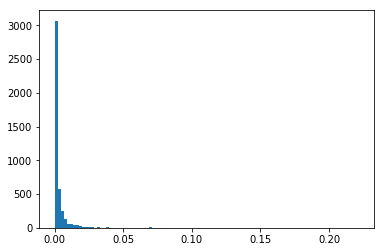

In [121]:
#visualize the missing_rate_at_high_missing_region
plt.hist(missing_rate_at_high_missing_region, bins=100)
plt.show()

In [122]:
#preprocess generate a pandas table to store high missing rate and gene names
gene_names = list(sections.values())
gene_ids = list(sections.keys())
table = pd.DataFrame({'gene_name':gene_names, 
                      'gene_ids':gene_ids,
                      'row_id':np.arange(4345),
                      'missing_rate': missing_rate_at_high_missing_region})

In [123]:
#visualize the top genes that has low missing at the high missing region
table.sort_values('missing_rate', ascending=False).head(40)

,gene_name,gene_ids,row_id,missing_rate
1323,Eps15l1,2193,1323,0.221861
1123,Fam60a,1878,1123,0.221756
3954,Gpd1l,74988763,3954,0.196186
3958,Gm1335,74988767,3958,0.184642
517,Reln,890,517,0.179703
422,Npy,717,422,0.178963
3957,Lamc2,74988766,3957,0.177721
3487,Tac1,1038,3487,0.176823
3906,Lhx2,79568024,3906,0.174710
3959,Glul,74988768,3959,0.173310


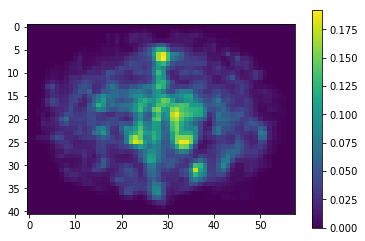

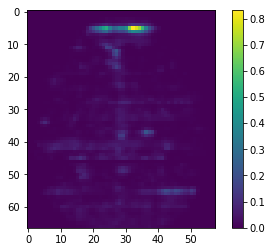

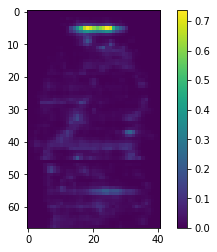

In [124]:
#visualize a specific gene in the gene_index
i = 2061
plt.figure()
plt.imshow(np.sum(np.maximum(data[i],0), 0))
plt.colorbar()
plt.figure()
plt.imshow(np.sum(np.maximum(data[i],0), 1))
plt.colorbar()
plt.figure()
plt.imshow(np.sum(np.maximum(data[i],0), 2))
plt.colorbar()
plt.show()

In [60]:
#preprocess filter out the genes that have significant non-missing at high missing rate region
keep = missing_rate_at_high_missing_region < 0.04
data = data[keep]

In [125]:
#preprocess add missing values proportional to the current missing rate
missing_rate = np.mean(data < 0, axis=0)
missing_rate = missing_rate * selected[0]
total_missing_rate = 0.20 # used to be 0.05
#missing_rate *= total_missing_rate / np.mean(missing_rate) * np.mean(selected) 
missing_mask = np.logical_and((data >= 0) * selected, 
                              np.random.uniform(0, 1, size=data.shape) < total_missing_rate) 

In [132]:
#preprocess add missing values proportional to the current missing rate - Segmented missing
missing_rate = np.mean(data < 0, axis=0)
missing_rate = missing_rate * selected[0]
total_missing_rate = 0.20 # used to be 0.05
#missing_rate *= total_missing_rate / np.mean(missing_rate) * np.mean(selected) 
missing_mask = np.logical_and((data >= 0) * selected, 
                              np.tile(np.random.uniform(0, 1, size=data.shape[:2]) < total_missing_rate,(1,1,data.shape[2],data.shape[3])))

ValueError: operands could not be broadcast together with shapes (4345,67,41,58) (1,1,178145,3886) 

In [126]:
#visualize the overall missing rate at the selected region
print("The ratio of missing data is {}.".format(
    np.mean(missing_mask[:,selected[0]]) / np.mean((data >= 0)[:,selected[0]])))

The ratio of missing data is 0.19999288648814895.


In [127]:
#store_data
np.savez('../data/filtered_data_with_missing_20_percent.npz', 
         missing_mask=missing_mask, 
         data = data,
         region_of_interest=selected)